# 定义网络结构

## 导入工具包

In [86]:
from tensorflow.keras import Input,Model,models
from tensorflow.keras.layers import Embedding, Dense, Conv1D, GlobalMaxPooling1D, Concatenate, Dropout
from tensorflow.keras.models import load_model

## 建立TextCNN类

In [87]:
class TextCNN(object):
    def __init__(self,maxlen,max_features,embedding_dims,class_num=5,last_activation='softmax'):
        self.maxlen = maxlen
        self.max_features = max_features
        self.embedding_dims = embedding_dims
        self.class_num = class_num
        self.last_activation = last_activation
    def get_model(self):
        input = Input((self.maxlen,)) # 输入# 这里就是所有文本(句子)的最大长度,1维度,也表示成1维度里含有最大的元素数
        embedding = Embedding(self.max_features,self.embedding_dims,input_length=self.maxlen)(input) #词向量化
        convs = [] 
        for kernel_size in [3,4,5]: #设定filter大小
            c = Conv1D(128,kernel_size,activation='relu')(embedding)
            c = GlobalMaxPooling1D()(c)
            convs.append(c)
        x = Concatenate()(convs)
        
        output = Dense(self.class_num,activation=self.last_activation)(x)
        model = Model(inputs=input,outputs=output)
        return model

## 数据处理与训练

In [88]:
from tensorflow.keras.preprocessing import sequence
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
from utils import *

In [89]:
#路径配置
data_dir = './processed_data'
vocab_file = '../vocab/vocab.txt'
vocab_size = 40000
#神经网络配置
max_features = 40001
maxlen = 100
batch_size = 64
embedding_dims = 50
epochs = 8

print('数据预处理与加载...')

#如果不存在词汇表,重建
if not os.path.exists(vocab_file):
    build_vocab(data_dirr, vocab_file, vocab_size)
# 获取 词汇/类别 与id映射字典
categories, cat_to_id = read_category()
words, word_to_id = read_vocab(vocab_file)

# 全部数据
contents, labels = read_files(data_dir)
data = list(zip(contents,labels))

数据预处理与加载...


In [90]:
#乱序
random.shuffle(data)
#切分训练集和测试集
train_data,test_data = train_test_split(data)


In [91]:
train_data[1]

(['中新网',
  '深圳',
  '日电',
  '郑小红',
  '深圳市人民政府',
  '数字',
  '中国',
  '联合会',
  '举办',
  '主题',
  '迈进',
  '智能',
  '时代',
  '2017',
  '中国',
  '深圳',
  'IT',
  '领袖',
  '峰会',
  '深圳',
  '马云',
  '李彦宏',
  '马化腾',
  '朱民',
  '行业',
  '领袖',
  '知名',
  '学者',
  '再度',
  '同台',
  '智能',
  '时代',
  '揭示',
  '行业',
  '未来',
  '发展趋势'],
 'technology')

In [92]:
x_train = encode_sentences([content[0] for content in train_data], word_to_id)
y_train = to_categorical(encode_cate([content[1] for content in train_data], cat_to_id))#转成one_hot编码
x_test = encode_sentences([content[0] for content in test_data], word_to_id)
y_test = to_categorical(encode_cate([content[1] for content in test_data], cat_to_id))#转成one_hot编码

In [93]:
x_train

[[3133,
  2057,
  2435,
  1511,
  124,
  9367,
  1492,
  10,
  5078,
  12,
  1511,
  341,
  642,
  10,
  303,
  2057,
  1606,
  9227,
  2760,
  9791,
  3033,
  124,
  74,
  56,
  11533],
 [43,
  508,
  27,
  19249,
  40000,
  414,
  1,
  3386,
  242,
  342,
  7645,
  29,
  99,
  12,
  1,
  508,
  2164,
  3877,
  1417,
  508,
  4108,
  3279,
  7226,
  40000,
  18,
  3877,
  613,
  5334,
  1159,
  2340,
  29,
  99,
  8439,
  18,
  23,
  2713],
 [1229,
  11289,
  12289,
  3215,
  5098,
  40000,
  12430,
  40000,
  22,
  49,
  106,
  722,
  2,
  4400,
  1229,
  261,
  22,
  318,
  352,
  35903],
 [10721,
  502,
  10824,
  1267,
  10824,
  1322,
  220,
  359,
  2,
  4706,
  1322,
  220,
  156,
  2,
  9360,
  25,
  990,
  146,
  261,
  724,
  146,
  4706,
  183,
  724,
  146,
  783,
  394,
  67,
  2610,
  183,
  1319,
  25,
  1356,
  4176,
  284,
  25,
  14100,
  5054,
  502,
  7916,
  888,
  1322,
  359,
  220,
  2],
 [2091,
  11886,
  4477,
  9272,
  1565,
  2120,
  4,
  7430,
  319,
  691

In [81]:
print('对序列做padding，保证是 samples*timestep 的维度')

对序列做padding，保证是 samples*timestep 的维度


In [94]:
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

x_train shape: (65810, 100)
x_test shape: (21937, 100)


## 构建模型

In [95]:
model = TextCNN(maxlen,max_features,embedding_dims).get_model()
model.compile('adam','categorical_crossentropy',metrics=['accuracy'])
print('训练...')

训练...


## 回调函数

In [96]:
my_callbacks = [ModelCheckpoint('../model/cnn_model.h5',verbose=1),EarlyStopping(monitor='val_accuracy',patience=2,mode='max')]

## fit拟合数据

In [97]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          callbacks=my_callbacks,
          validation_data=(x_test, y_test))

Train on 65810 samples, validate on 21937 samples
Epoch 1/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.4682 - accuracy: 0.8359
Epoch 00001: saving model to ../model/cnn_model.h5
65810/65810 [==============================] - 111s 2ms/sample - loss: 0.4682 - accuracy: 0.8359 - val_loss: 0.2744 - val_accuracy: 0.9052
Epoch 2/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.1588 - accuracy: 0.9467
Epoch 00002: saving model to ../model/cnn_model.h5
65810/65810 [==============================] - 98s 1ms/sample - loss: 0.1588 - accuracy: 0.9467 - val_loss: 0.2847 - val_accuracy: 0.9071
Epoch 3/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.0809 - accuracy: 0.9720
Epoch 00003: saving model to ../model/cnn_model.h5
65810/65810 [==============================] - 98s 1ms/sample - loss: 0.0810 - accuracy: 0.9720 - val_loss: 0.3253 - val_accuracy: 0.9042
Epoch 4/8
65792/65810 [============================>.] - ETA: 0s - loss: 0.0553 - acc

# 训练中建信息输出

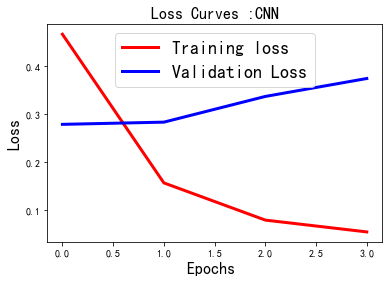

In [61]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
%matplotlib inline

fig1 = plt.figure()
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves :CNN',fontsize=16)
fig1.savefig('loss_cnn.png')
plt.show()

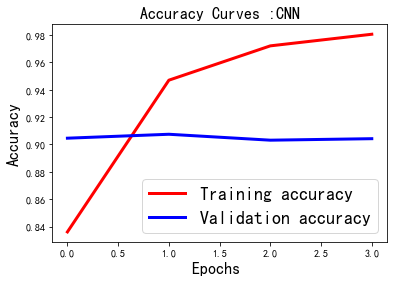

In [62]:
fig2 = plt.figure()
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training accuracy', 'Validation accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves :CNN',fontsize=16)
fig1.savefig('accuracy_cnn.png')
plt.show()

In [1]:
from tensorflow.keras.models import load_model
model = load_model('./cnn_model.h5')

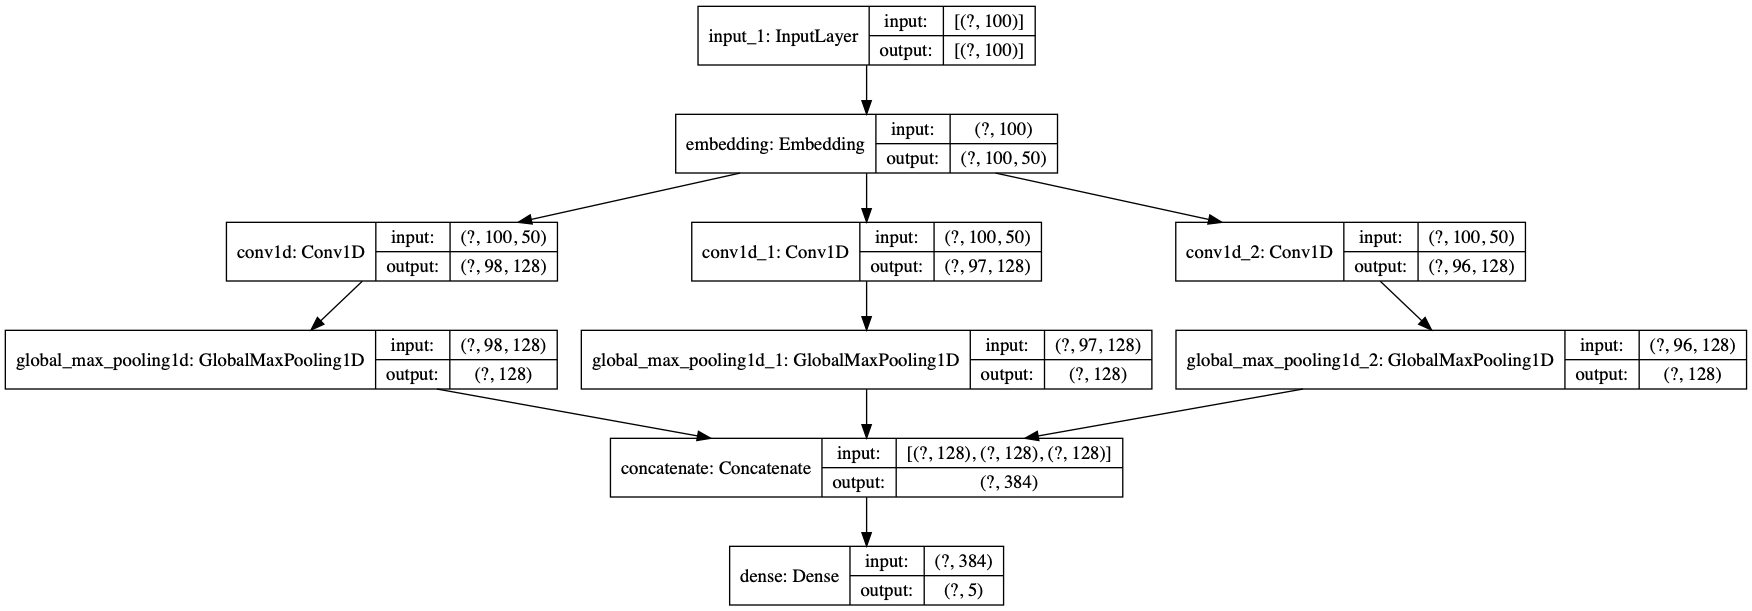

In [4]:
from tensorflow.keras.utils import plot_model
plot_model(model,show_shapes=True)